In [1]:
import sys

sys.path.append('../')

In [ ]:
import numpy as np
from config.transformers import EmgFilterTransformer, EMGPreprocessor, IEMGFilterTransformer
import matplotlib.pyplot as plt

In [ ]:
# Example assuming X_train_raw already loaded
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project'
X = np.load(PATH + '/data/guided/guided_dataset_X.npy')

print(f"Original EMG shape: {X.shape}")  # (5 sessions, 8 channels, 230000 samples)

# Preprocess EMG
X_train_processed = EMGPreprocessor().fit_transform(X)

print(f"Filter EMG shape: {X_train_processed.shape}")

Original EMG shape: (5, 8, 230000)
Filter EMG shape: (5, 8, 230000)


In [9]:
def plot_emg_all_channels(signal, fs=1024, duration_sec=4, title="EMG Signal (All Channels)"):
    """
    Plots all EMG channels in a single graph for the specified duration.

    Args:
        signal (np.ndarray): shape (channels, time)
        fs (int): sampling frequency in Hz
        duration_sec (float): duration to plot in seconds
        title (str): title of the plot
    """
    n_channels, n_samples = signal.shape
    max_samples = int(fs * duration_sec)
    t = np.arange(max_samples) / fs

    plt.figure(figsize=(12, 5))
    for i in range(n_channels):
        plt.plot(t, signal[i, :max_samples], label=f'Channel {i}')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

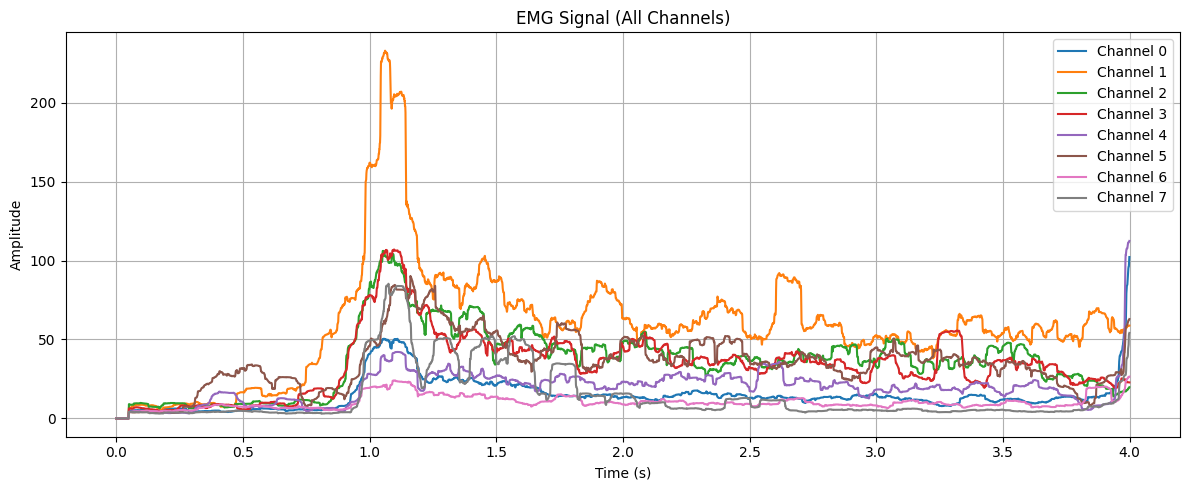

In [10]:
plot_emg_all_channels(X_train_processed[0], fs=1024, duration_sec=4)

In [11]:
# Preprocess EMG
X_train_processed = EmgFilterTransformer().fit_transform(X)

print(f"Filter EMG shape: {X_train_processed.shape}")

Filter EMG shape: (5, 8, 230000)


Original signal


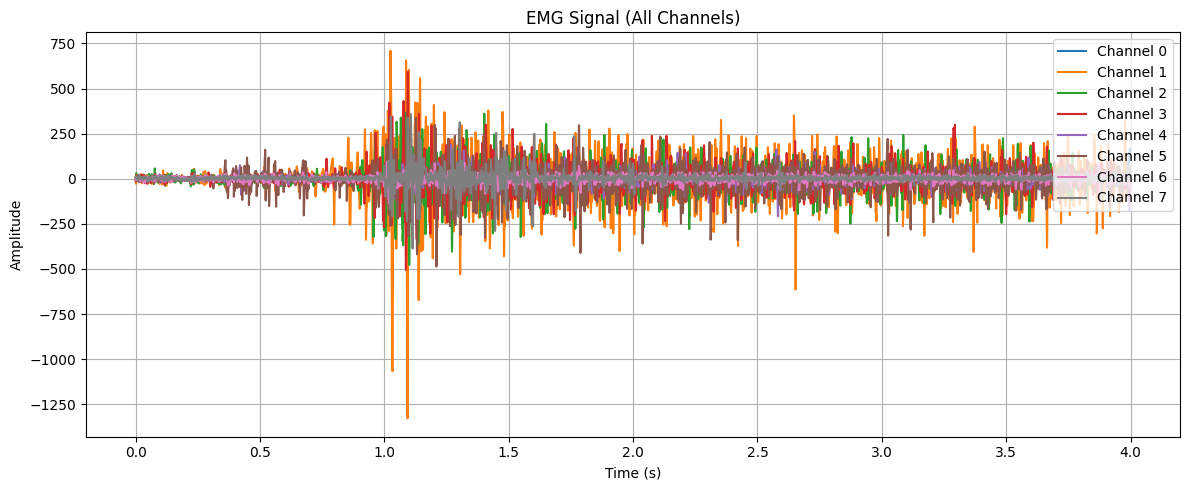

Filter signal


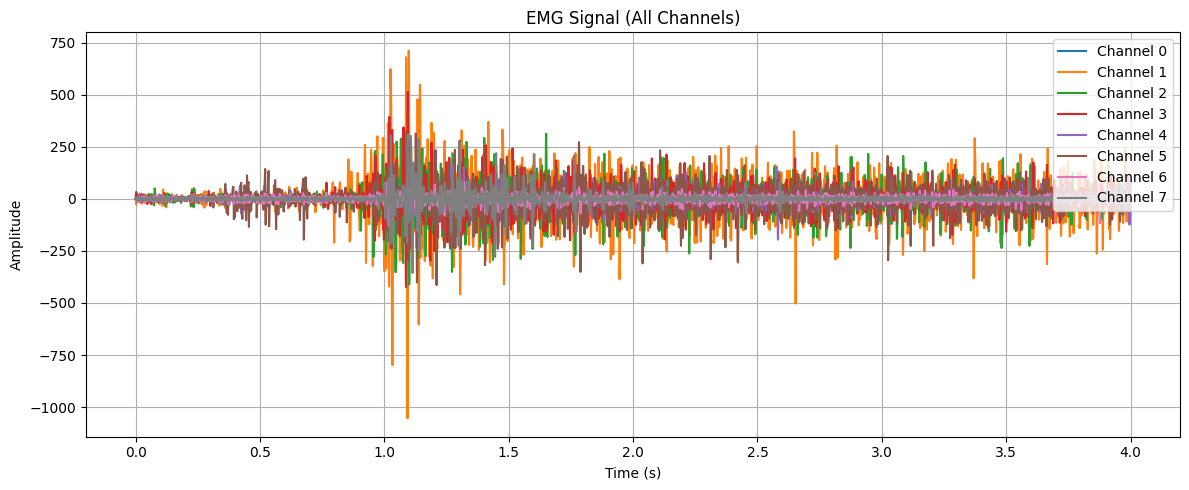

In [13]:
print("Original signal")
plot_emg_all_channels(X[0], fs=1024, duration_sec=4)
print("Filter signal")
plot_emg_all_channels(X_train_processed[0], fs=1024, duration_sec=4)

In [ ]:
# Preprocess EMG
X_train_processed = IEMGFilterTransformer().fit_transform(X)

print(f"Filter EMG shape: {X_train_processed.shape}")

Filter EMG shape: (5, 8, 230000)


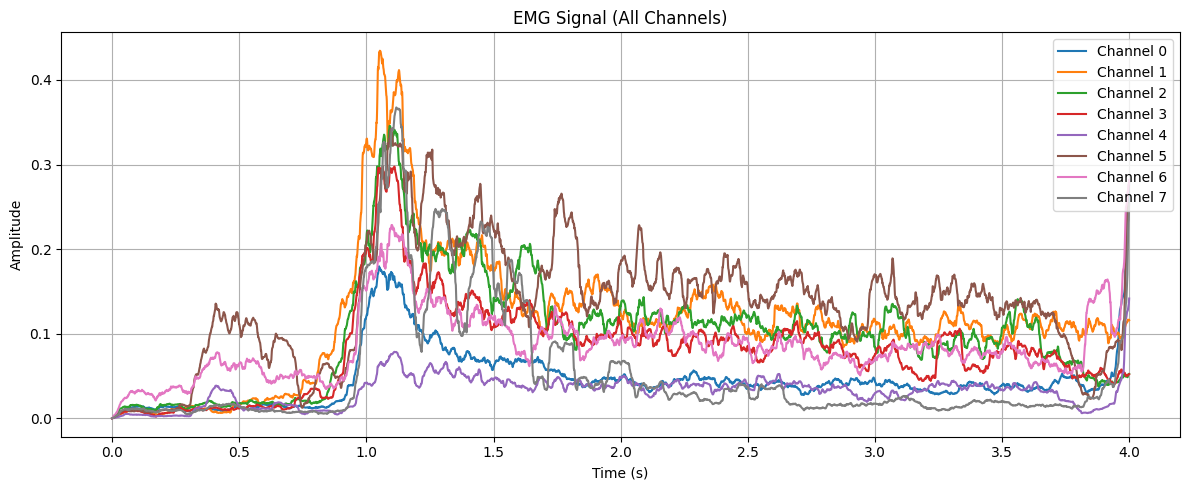

In [20]:
plot_emg_all_channels(X_train_processed[0], fs=1024, duration_sec=4)